<a href="https://colab.research.google.com/github/JuanKyBF/Pagina-Web/blob/main/Cuaderno_Lab_%C3%93ptica_Difractiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Funciones/Código Python

## Librerías
Ejecutar inicialmente para cargar las librerías y módulos empleados

In [6]:
import os
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display, Latex
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [7]:
#@title Montar Google Drive para leer TXT
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## TOC


---


*   ***readTXTLabViewRec()*** $\Rightarrow$ Lee el archivo txt del registro de hologramas de LabView, devuelve un array tipo [Tiempo, PotenciaDifractada, PotenciaTransmitida]


*   ***PlotRecording()*** $\Rightarrow$ Devuelve una gráfica del registro del holograma, representando la potencia difractada y transmitida con el paso del tiempo


* ***readTXTLabViewAC()*** $\Rightarrow$ Lee el archivo txt de la reconstrucción de hologramas de LabView, devuelve un array tipo [Angulo, PotenciaDifractada, PotenciaTransmitida]

* ***PlotRecAngular()*** $\Rightarrow$ Devuelve una gráfica de la reconstrucción del holograma, representando la potencia difractada y transmitida con el barrido angular $\theta$


* ***DiffractionEfficency()*** $\Rightarrow$ Devuelve el valor de la Eficiencia en Difracción.

* ***TransmissionEffiency()*** $\Rightarrow$ Devuelve el valor de la Eficiencia en Transmisión

* ***AngularNorm()*** $\Rightarrow$ función que devuelve un array tipo [Ángulos, Potencia Difracción Normalizada, Potencia Transmisión Normalizada]

 * ***PlotRecAngularNorm()*** $\Rightarrow$ Devuelve una gráfica de la reconstrucción del holograma normalizada. En la leyenda muestra la DE o TE según la opción que pongamos

* ***Snell()*** $\Rightarrow$ Recibe de inputs el ángulo incidente respecto a la normal, y los índices de refracción del medio y del aire, devolviendo el ángulo refractado en el material.


* ***Registro()*** $\Rightarrow$ Devuelve el periodo de la red $\Lambda$ y la inclinación de la misma $\phi$. Le pasamos de input, la longitud de onda de registro *lambda_reg* en micras (normalmente $\color{green}{\lambda_{\text{reg}}=533\times 10^{-3} \hspace{0.1cm} \text{ $\mu$m}}$), *theta_ref* el ángulo del haz referencia, *theta_obj* el ángulo del brazo objeto y *n_0* el índice de refracción del material

* ***BraggAngle()*** $\Rightarrow$ Devuelve los valores del ángulo de Bragg, tenemos que pasarle de input la longitud de onda de reconstrucción *lambda_rec* $\lambda_{\text{rec}}$, el periodo de la red *lambda_red* $\Lambda$, y el ángulo de inclinación de las franjas $\phi$

* ***KogelnikFunc()*** $\Rightarrow$ Devuelve la eficiencia en difracción o eficiencia en transmisión para la formulación de Kogelnik, recibe como parámetros la longitud de onda de reconstrucción $\lambda_\text{rec}$, el perido de la red $\Lambda$, el ángulo de inclinación de las franjas de difracción $\phi$, los ángulos $\theta$, el índice de refracción del aire $n_0$ y del medio $n_1$, junto al espesor $d$, y las constantes de absorción $\alpha$ y $\alpha_1$. El último input es la opción *opt*, donde elegiremos entre Transmisión 'TE' o Difracción 'DE'

* ***CompararExpKogelnik()*** $\Rightarrow$ Devuelve una representación de los datos experimentales junto al ajuste de kogelnik, obteniendo así

* ***Comparar(n0,Datos,lambda_rec,lambda_red,phi)*** $\Rightarrow$ Función que devuelve una curva teórica ajustada con las funciones de Kogelnik a la curva experimental. También devuelve el espesor teórico y la modulación de índice teórica


In [24]:
 #@title Funciones


def readTXTLabViewRec(name):
    file = open(name, "r") # Abrimos TXT

    for line in file:
        A = file.readlines() # Hacemos un array del contenido de las filas

    for i in range(len(A)):
        A[i] = A[i].replace('\n'," ") # Cambiamos los saltos de línea por espacios
        A[i] = A[i].replace('\t'," ") # Cambiamos las tabulaciones por espacios
        A[i] = A[i].split() # Separamos el contenido de la fila formando un array

    Datos = np.empty((len(A),3)) # Matriz de datos
    for i in range(len(Datos)):
        Datos[i][0] = float(A[i][0])*1e3 # Pot Diff  (mW)
        Datos[i][1] = float(A[i][1])*1e3 # Pot Trans (mW)
        Datos[i][2] = float(A[i][2])*2    # Tiempo   (s)

    file.close() # Cerramos el archivo para evitar problemas

    return Datos


def PlotRecording(name,txtname):
  time = readTXTLabViewRec(name)[:,2]
  PDiff = readTXTLabViewRec(name)[:,0]
  PTrans = readTXTLabViewRec(name)[:,1]

  plt.figure()
  plt.plot(time,PTrans,'-o',c='tab:orange',label='Transmitido')
  plt.plot(time,PDiff,'-o',c='tab:blue',label='Difractado')
  plt.xlabel('Tiempo (s)')
  plt.ylabel('Irradiancia ($m W/cm^2$)')
  plt.legend(loc='best')
  plt.title('Reconstrucción '+txtname)
  plt.grid()
  plt.show()



def readTXTLabViewAC(name):
    file = open(name, "r") # Abrimos TXT

    for line in file:
        A = file.readlines() # Hacemos un array del contenido de las filas

    for i in range(len(A)):
        A[i] = A[i].replace('\n'," ") # Cambiamos los saltos de línea por espacios
        A[i] = A[i].replace('\t'," ") # Cambiamos las tabulaciones por espacios
        A[i] = A[i].split() # Separamos el contenido de la fila formando un array

    Datos = np.empty((len(A),3)) # Matriz de datos
    for i in range(len(Datos)):
        Datos[i][0] = float(A[i][0])     # Angulo
        Datos[i][1] = float(A[i][1])*1e3 # Pot Diff  (mW)
        Datos[i][2] = float(A[i][2])*1e3 # Pot Trans (mW)

    file.close() # Cerramos el archivo para evitar problemas

    return Datos




def PlotRecAngular(name,txtname):

  Angle = readTXTLabViewAC(name)[:,0]
  PDiff = readTXTLabViewAC(name)[:,1]
  PTrans = readTXTLabViewAC(name)[:,2]

  plt.figure()
  plt.plot(Angle,PTrans,'-o',c='tab:orange',label='Transmitido')
  plt.plot(Angle,PDiff,'-o',c='tab:blue',label='Difractado')
  plt.xlabel('Ángulo ($^{\\circ}$)')
  plt.ylabel('Irradiancia ($m W/cm^2$)')
  plt.legend(loc='best')
  plt.title('Reconstrucción '+txtname)
  plt.grid()
  plt.show()


def DiffractionEfficency(name):
  PDiff = readTXTLabViewAC(name)[:,1]
  PTrans = readTXTLabViewAC(name)[:,2]
  DE = np.max(PDiff)/np.max(PTrans)*100

  return DE


def TransmissionEffiency(name):
  PDiff = readTXTLabViewAC(name)[:,1]
  PTrans = readTXTLabViewAC(name)[:,2]
  TE = (1-np.min(PTrans)/np.max(PTrans))*100

  return TE




def AngularNorm(name,txtname):
  Angle = readTXTLabViewAC(name)[:,0]
  PDiff = readTXTLabViewAC(name)[:,1]
  PTrans = readTXTLabViewAC(name)[:,2]
  PDiffNorm = PDiff/np.max(PTrans)*100
  PTransNorm = PTrans/np.max(PTrans)*100

  DE = round(DiffractionEfficency(name),2)
  return [Angle,PDiffNorm,PTransNorm]



def PlotRecAngularNorm(name,txtname,opt):
  Angle = AngularNorm(name,txtname)[0]

  if opt == 'DE':
    P = AngularNorm(name,txtname)[1]
    E = round(DiffractionEfficency(name),2)

  elif opt == 'TE':
    P = AngularNorm(name,txtname)[2]
    E = round(TransmissionEffiency(name),2)


  plt.figure()
  plt.plot(Angle,P,'-o', c='tab:blue', label= opt +'=' + str(E) +'%')
  plt.xlabel('Ángulo ($^{\\circ}$)')
  plt.ylabel(opt +'(%)')
  plt.legend(loc='best')
  plt.title(opt+txtname)
  plt.grid()
  plt.show()




def Snell(theta1,n1,n2):
  theta2 = np.arcsin(n1/n2*np.sin(theta1))
  return theta2




def Registro(lambda_reg, theta_ref, theta_obj, n0):

  beta = 2*np.pi*n0/lambda_reg # Factor beta para obtener el periodo (lambda_red)
  theta2_ref = Snell(theta_ref, 1, n0) # Angulo referencia refractado en el material
  theta2_obj = Snell(theta_obj, 1, n0) # Ángulo objeto refractado en el material

  K = 2*beta*np.sin((theta2_ref- theta2_obj)/2) # Módulo vector de red K en el material
  lambda_red = 2*np.pi/K # El periodo espacial sería 1/(lambda_red*1e-3) (lambda_red está en micras/linea) [líneas/mm]

  if theta2_obj != -theta2_ref:
      phi = np.arctan((np.sin(theta2_obj) - np.sin(theta2_ref)) / (np.cos(theta2_obj) - np.cos(theta2_ref)))
  else:
      phi = np.pi/2  # Ángulo de 90 grados en caso de que theta2_obj sea igual a theta2_ref

  return lambda_red, phi



def BraggAngle(lambda_reg, n0, Lambda_red, phi):


  K = 2*np.pi/Lambda_red
  beta = 2*np.pi*n0/lambda_reg

  theta_bragg = [phi-np.arccos(K/(2*beta)), phi + np.arccos(K/(2*beta))]

  return theta_bragg




def KogelnikFunc(lambda_rec,lambda_red,phi,Theta,n0,n1,d,alpha,alpha1,opt):
  Theta2 = Snell(Theta,1,n0)

  K = 2*np.pi/lambda_red
  beta = 2*np.pi*n0/lambda_rec

  cR = np.cos(Theta2)
  cS = np.cos(Theta2)-K/beta*np.cos(phi)

  dephasing = K*(np.cos(Theta2-phi)-K/2/beta)
  xi = d/2*(alpha*(1/cR-1/cS)-1j*dephasing/cS)

  kappa = np.pi*n1/lambda_rec - 1j*alpha1/2
  nu = kappa*d/np.sqrt(cR*cS)

  #S = -1j*np.sqrt(cR/cS)*np.exp(xi-alpha*d/cR)*np.sin(np.sqrt(nu**2-xi**2))/np.sqrt(1-xi**2/nu**2)


  g1 = -(alpha/cR+alpha/cS+1j*dephasing/cS)/2 + np.sqrt((alpha/cR-alpha/cS-1j*dephasing/cS)**2-4*kappa**2/cR/cS)/2
  g2 = -(alpha/cR+alpha/cS+1j*dephasing/cS)/2 - np.sqrt((alpha/cR-alpha/cS-1j*dephasing/cS)**2-4*kappa**2/cR/cS)/2

  if opt == 'DE':
    S_kog = 1j*kappa/cS/(g1-g2)*(np.exp(g2*d)-np.exp(g1*d))
    DE = np.abs(cS)/cR*np.abs(S_kog)**2
    return DE

  elif opt == 'TE':
    R_kog = kappa**2/cS/(g1-g2)*(np.exp(g2*d)/(cR*g2+alpha)-np.exp(g1*d)/(cR*g1+alpha))
    TE = np.abs(R_kog)**2
    return TE







def Comparar(n0,Datos,lambda_rec,lambda_red,phi):

  # Yexp es una matriz que contiene [Angles, Pots]
  Angles = Datos[0] ; Pexp = Datos[1] # Los guardamos por separado
  Ajuste = []; Datos_exp = [] # Matrices para guardar los datos del ajuste y los experimentales

  AngleB = Angles[Pexp.argmin()] # Localizamos el ángulo de Bragg (cogemos el ángulo de la mínima potencia que se da por TE)


  BA = BraggAngle(lambda_rec,n0,Lambda_red,phi)
  AngleB -= Snell(BA,n0,1)[0]*180/np.pi #OJO!
  AnglesC = Angles-AngleB; ThetasC = Angles # Angulos sin desviar, y ángulos desviados respecto a la condición de Bragg

  exp0 = np.abs(AnglesC).argmin()
  teo0 = np.abs(ThetasC).argmin()

  N = len(Angles)

  n1_list = np.arange(1e-4,0.2*n0,5e-4) # Array de posibles valores de modulación de índice
  d_list  = np.arange(50.,300.,1)      # Array de posibles valores de espesor (micras)
  k_min = np.zeros(len(d_list),dtype=int) # Array de iteraciones para minimizar
  desvRs = np.zeros(len(d_list))
  delta1 = np.min([exp0+1,teo0+1])-1; delta2 = np.min([N-(exp0+1), N-(teo0+1)])-1


  # Recorremos los valores de d y n1 para encontrar el que mejor se ajusta
  for j in range(len(d_list)):
      desvA_n1 = np.zeros(len(n1_list))
      for k in range(len(n1_list)):
        Pteo = 100*KogelnikFunc(lambda_rec,lambda_red,phi,Angles,n0,n1_list[k],d_list[j],0,0,'TE')
        EXP = Pexp[exp0-delta1:exp0+delta2] # Obtenemos diferentes curvas de Kogelnik en TE en cada iteración
        TEO = Pteo[teo0-delta1:teo0+delta2]
        desvA_n1[k] = LA.norm(EXP - TEO) # diferencia experimental - teorico minimizada por Linear Alg

      desvR_n1 = desvA_n1/LA.norm(Pexp[exp0-delta1:exp0+delta2]) # Al minimizar obtenemos el valor de la desviación de n1 para pasar al espesor d
      k_min[j] = np.int64(desvR_n1.argmin()) # este es el índice que corresponde al valor óptimo de n1 para el espesor d_list[j]
      desvRs[j] = desvR_n1[k_min[j]] # Desviación de n1

  i_min = desvRs.argmin() # de todos los pares (n1,d) ahora nos quedamos con el que mejor ajusta los datos a partir del índice que corresponde en d_list
  n1teo = n1_list[k_min][i_min] # Obtenemos nuestra modulación de índice que más se ajusta a nuestros datos experimentales
  dteo = d_list[i_min] # Obtenemos nuestro espesor que más se ajusta a nuestros datos experimentales
  Pteo = 100*(KogelnikFunc(lambda_rec,lambda_red,phi,Angles*np.pi/180,n0,n1teo,dteo,0,0,'TE')) # Obtenemos la curva más parecida teóricamente según Kogelnik

  Ajuste.append([Angles,Pteo])
  Datos_exp.append([Angles,Pexp])

  return Ajuste, Datos_exp, dteo, n1teo

# Libreta

## 25 de Mayo de 2023
1 Preparación de PVA/AA (El número es el orden de adición)



---

$\text{Hora}:$  $13$ $\text{p.m.}$

$T = 22 ^{\circ} C$

$H= 61 \%$

---



1.   BMA -> $0.1007$ $\text{g}$
2.   PVA 8% -> $10$ $\text{mL}$ (15 min a 80 r.p.m)
3.   TEA+AA 1M -> $1400$ $\mu \text{L}$ (10 min a 100 r.p.m.)
4.   TEA (puro) -> $200$ $\mu \text{L}$ (10 min a $\leq$100 r.p.m.)
5.   YEosine -> $280$ $\mu \text{L}$ (6 min a $\leq$100 r.p.m.) **LUZ ROJA**

\\
En la pipeta pusimos $210$ $\mu \text{L}$ de TEA porque es muy viscoso

---
Ya que con el microscopio es una puta mierda medir los espesores vamos a proceder de la siguiente manera:


1.   Montaje Holográfico de fuera para registrar hologramas de $\Lambda = 1000 $ $\text{líneas}/\text{mm}$. Registramos el holograma en la muestra de PVA/AA sin coverplatting y reconstruimos para obtener la respuesta angular del material. Posteriormente con el programa de comparación con la teoría de Kogelnik analizamos la reconstrucción y obtenemos el espesor del material. Para tener un poco más de fiabilidad en cuanto a la medición del espsor registraremos 3 hologramas en el mismo material y mediremos los espesores para realizar una media.

2.   Siempre que preparemos PVA/AA haremos un número par de placas para el mismo volumen de fotopolímero, una será para medir el espesor y otra para registrar DOEs. Pudiendo así estimar el espesor $d$

3. La deposición deberá de ser lo más homogénea posible y registrar siempre en las zonas más centrales (evitar bordes). El vidrio para registrar hologramas no deberá de tener coverplate.




## 29 de Mayo de 2023
1 Preparación de PVA/AA (El número es el orden de adición)



---

$\text{Hora}:$  $12$ $\text{p.m.}$

$T = 23 ^{\circ} C$

$H= 58 \%$

---



1.   BMA -> $0.1012$ $\text{g}$
2.   PVA 8% -> $10$ $\text{mL}$ (15 min a 80 r.p.m)
3.   TEA+AA 1M -> $1400$ $\mu \text{L}$ (10 min a 100 r.p.m.)
4.   TEA (puro) -> $200$ $\mu \text{L}$ (10 min a 100 r.p.m.)
5.   YEosine -> $280$ $\mu \text{L}$ (6 min a 100 r.p.m.) **$\color{red}{\text{LUZ ROJA}}$**

---


2 Registro de Hologramas en Bayfol HX200 de covestro.
Con el montaje de la anterior página pegaremos el film del Bayfol a los vidrios de $6,5 \times 4 \hspace{0.1cm} \text{cm}^2$ y registraremos varios hologramas. NO usar luz roja, pues el bayfol es sensible en el espectro $\lambda \in [400,680] \hspace{0.1cm} \text{nm}$. Ver

 https://solutions.covestro.com/en/products/bayfol/bayfol-hx200_86194384-20033146?SelectedCountry=US


 Registrar solo con luz verde y evitar tener burbujas en la zona de interferencia entre haces.

 Los ángulos de registro son $\theta_{\text{Ref}}=16.05^{\circ }$ y $\theta_{\text{Obj}}=-16.05^{\circ }$ respecto a la normal del plano de la muestra.

 Se han registrado 3 hologramas con distintos tiempos de exposición $3 \hspace{0.1cm} \text{min}=180 \hspace{0.1cm}s$, $4 \hspace{0.1cm} \text{min}=240 \hspace{0.1cm}s$ y $5 \hspace{0.1cm} \text{min}=300 \hspace{0.1cm}s$. Para una relación de intensidades $(2.1 \hspace{0.1cm} \text{mW}:2 \hspace{0.1cm} \text{mW}\equiv 1:1)$





---

Ángulos del montaje y montaje experimental:

Según el ángulo $\theta$ con el que incidan los dos haces se registrarán franjas sinusoidales con una frecuencia determinada, pues el patrón de interferencia de dos ondas planas que inciden formando un ángulo $\theta$ es:

\begin{equation}
I(x) = I_1 + I_2 + 2 \sqrt{I_1 I_2} \cos \left( \frac{2 \pi x}{\Lambda}\right)
\end{equation}

donde $\Lambda$ es el periodo espacial de la red, es decir, la distancia entre dos máximos o mínimos consecutivos del diagrama interferencial, el cual viene dado por la ley de Bragg:
\begin{equation}
\Lambda = \frac{\lambda}{2 \sin \theta}
\end{equation}

Donde $\lambda$ es la longitud de onda del láser de registro, He-Ne de $533 \hspace{0.1cm} \text{nm}$. En este montaje se emplean de ángulos de incidencia $-16.05^{\circ}$ y $+16.05^{\circ}$, registrándose una red de aproximadamente:
\begin{equation}
\Lambda = \frac{533 \times 10^{-6} \hspace{0.1cm} \text{mm}}{2 \sin(16.05)} \approx 0.96 \times 10^{-3} \hspace{0.1cm} \text{mm} \Rightarrow 1037 \hspace{0.1cm} \text{líneas/mm}
\end{equation}
Para obtener el ángulo de reconstrucción $\theta_{\text{Rec}}$ en el aire empleamos
\begin{equation}
n \lambda = 2 \Lambda \sin \theta_{\text{Rec}} \Rightarrow \theta_{\text{Rec}} = \arcsin\left( \frac{632 \times 10^{-6}}{2  \cdot 0.96\times 10^{-3}}  \right)= 19.14 ^{\circ}
\end{equation}

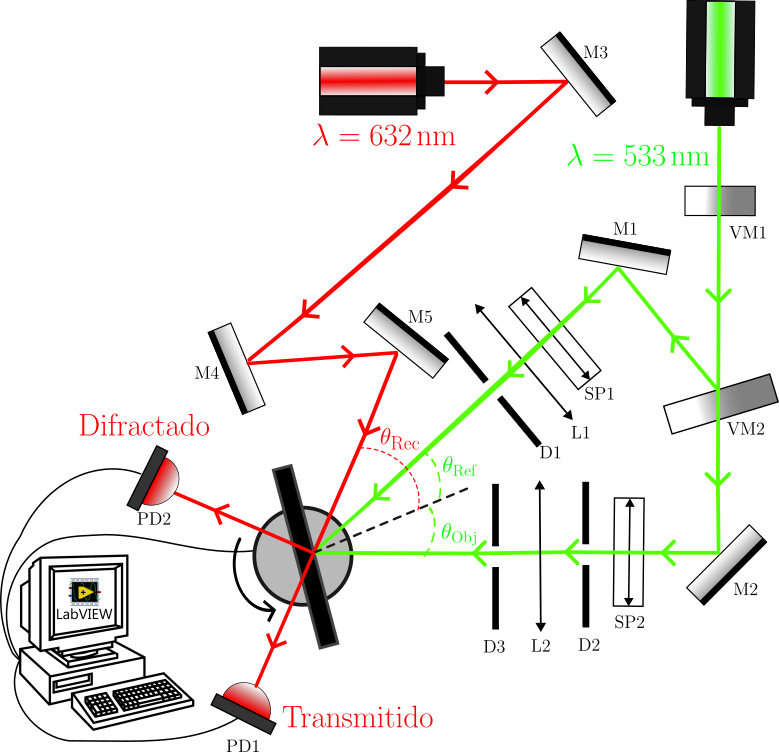

$\text{Mi}$ hace referencia a los Espejos, $\text{VMi}$ hace referencia a los espejos variables, $\text{SPi}$ al Filtro Espacial, $\text{Li}$ a las lentes (las cuales son ambas de focal $f' = 15$ $\text{cm}$, $\text{Di}$ serían los diafragmas y $\text{PDi}$ los Fotodetectores.

In [9]:
#@title Comprobación de periodo de la red $\Lambda$ y ángulo de Bragg $\theta_B$
lambda_rec = 632e-3
lambda_reg = 533e-3
n0 = 1.5

theta_ref, theta_obj = 16.05, -16.05

Lambda_red, phi = Registro(lambda_reg, theta_ref*np.pi/180, theta_obj*np.pi/180, n0)
theta_b1 = BraggAngle(lambda_rec, n0, Lambda_red, phi)[0]
theta_b2 = BraggAngle(lambda_rec, n0, Lambda_red, phi)[1]

print('Lambda_red =',round(1/Lambda_red/1e-3,2), ' líneas/mm')
print('phi =',round(phi*180/np.pi,2), '°')
print('theta_B1 =',round(theta_b1*180/np.pi,2), '°')
print('theta_B1 (aire)=', round(Snell(theta_b1,n0,1)*180/np.pi,2))
print('theta_B2 =',round(theta_b2*180/np.pi,2), '°')


Lambda_red = 1037.43  líneas/mm
phi = 90.0 °
theta_B1 = 12.62 °
theta_B1 (aire)= 19.14
theta_B2 = 167.38 °


Ponemos $n_0=1$, porque queremos saber el ángulo de Bragg fuera del material. Sabemos que por la ley de Snell tendremos que $n_0 \sin \theta_B = n_1 \sin \theta_B^{\hspace{0.1cm} \prime}$ y cuando salga del material $n_1 \sin \theta_B^{\hspace{0.1cm} \prime} = n_0 \sin \theta_B$. El índice de refracción del PVA/AA se puede medir con el refractómetro y es del orden de $n_1 = 1.477$

## 31 de Mayo de 2023

Registro de hologramas con el montaje anterior en PVA/AA elaborado el Lunes 29 de Mayo de 2023

---

$\text{Hora}:$  $10$:$30$ $\text{a.m.}$

$T = 23 ^{\circ} C$

$H= 64 \%$

---



El material con el prefijo $A$ hace referencia a que se ha depositado una cantidad de $1,8$ $\text{mL}$ de fotopolímero y $B$ a $1,5$ $\text{mL}$. Las intensidades de registro han sido de $1.1$ $\text{mW}$ y $1$ $\text{mW}$, relación ($1:1$) y la intensidad del haz rojo de $0.95$ $\text{mW}$.

En cuanto a los nombres de los archivos **TR** hace referencia a los registros (Time Recording) y **AS** a la reconstrucción (Angular Scan), el número delante de **A** o **B** indica el orden en el que se ha registrado el holograma, correspondiento cada número a un holograma distinto, luego va la fecha **310523**

---



In [10]:
#@title Elección txt


print('Selecciona un archivo:')
path = '/content/drive/MyDrive/DatosExperimentalesLab/Registros_Hologramas'
lista_nombres = os.listdir(path)
nametxt = widgets.Dropdown(options=lista_nombres)
nametxt



Selecciona un archivo:


Dropdown(options=('TR_PVA_310523_1A.txt', 'TR_PVA_310523_2A.txt', 'TR_PVA_310523_3B.txt', 'TR_PVA_310523_5B.tx…

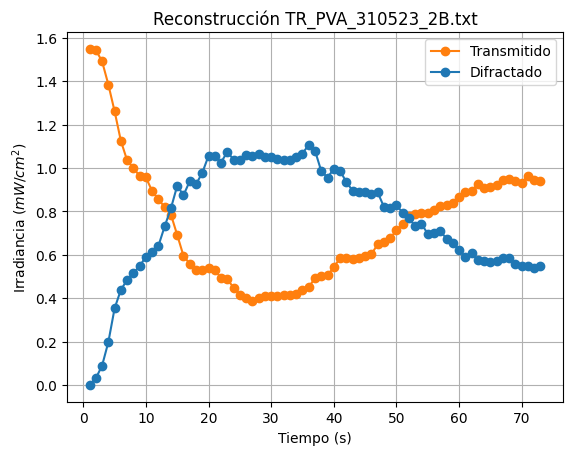

In [15]:
#@title Registro

# Nombre del path + archivo.txt seleccionado
txtname = nametxt.value
name = str(path + '/' + txtname)

PlotRecording(name,txtname)

In [16]:
#@title Elección txt

import os
import ipywidgets as widgets

print('Selecciona un archivo:')
path = '/content/drive/MyDrive/DatosExperimentalesLab/Reconstrucciones_Hologramas'
lista_nombres = os.listdir(path)
nametxt = widgets.Dropdown(options=lista_nombres)
nametxt

Selecciona un archivo:


Dropdown(options=('AS_PVA_310523_2B.txt', 'AS_PVA_310523_1A.txt', 'AS_PVA_310523_2A.txt', 'AS_PVA_310523_3B.tx…

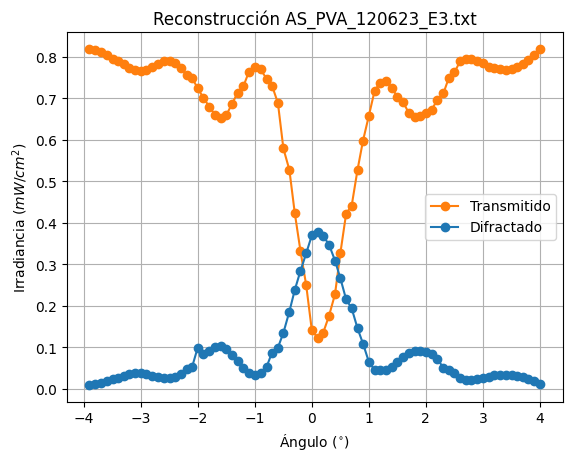

In [18]:
#@title Reconstrucciones Angulares

# Nombre del path + archivo.txt seleccionado
txtname = nametxt.value
name = str(path + '/' + txtname)


PlotRecAngular(name,nametxt.value)

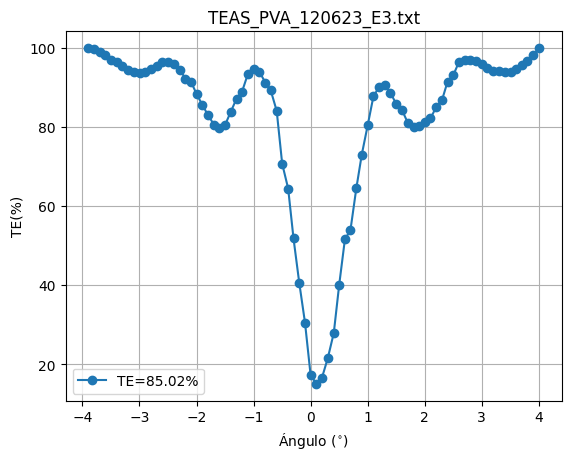

In [25]:
PlotRecAngularNorm(name,txtname,'TE')

In [ ]:
Datos = [AngularNorm(name,txtname)[0], AngularNorm(name,txtname)[2]]
Lambda_red, phi = Registro(lambda_reg, theta_ref, theta_obj, n0)
Ajuste, Datos_exp, dteo, n1teo = Comparar(n0,Datos,lambda_rec,Lambda_red,phi)

plt.plot(Ajuste, label='Ajuste teórico')
plt.plot(Datos_exp, label='Datos Experimentales')
plt.xlabel('Angulo de incidencia $(^{\circ})$')
plt.ylabel('TE')
plt.title('Ajuste realizado con $n_1=${} y $d=${}'.format(n1teo,dteo))
plt.legend(loc='best')
plt.grid()
plt.show()

## 12 de Junio de 2023

Registro de hologramas con el montaje anterior en PVA/AA elaborado el Lunes 6 de Junio de 2023

---


$\text{Hora}:$  $11$:$30$ $\text{a.m.}$

$T = 23 ^{\circ} C$

$H= 61 \%$

---




1.   BMA -> $0.1004$ $\text{g}$
2.   PVA 8% -> $10$ $\text{mL}$ (15 min a 80 r.p.m)
3.   TEA+AA 1M -> $1400$ $\mu \text{L}$ (10 min a 100 r.p.m.)
4.   TEA (puro) -> $210$ $\mu \text{L}$ (10 min a 100 r.p.m.)
5.   YEosine -> $280$ $\mu \text{L}$ (6 min a 100 r.p.m.) **$\color{red}{\text{LUZ ROJA}}$**

---
Identificación de vidrios y volúmenes empleados de fotopolímero

1. Vidrio A $\Rightarrow$ $1000$ $\mu \text{L}$
1. Vidrio B $\Rightarrow$ $1300$ $\mu \text{L}$
1. Vidrio C $\Rightarrow$ $1500$ $\mu \text{L}$
1. Vidrio D $\Rightarrow$ $1700$ $\mu \text{L}$
1. Vidrio E $\Rightarrow$ $700$ $\mu \text{L}$
1. Vidrio F $\Rightarrow$ $2000$ $\mu \text{L}$
---

Las intensidades de registro han sido de $1.01$ $\text{mW}$ y $0.95$ $\text{mW}$, relación ($1:1$) y la intensidad del haz rojo de $0.8$ $\text{mW}$.



---


# Teoría/Apuntes

## Ecuaciones de Kogelnik

Las ecuaciones de Kogelnik obtenidas por RCW al despreciar las segundas derivadas son las siguientes:

\begin{equation}
\begin{array}{cc}
  \boxed{c_R R' = -j \kappa S} \\
  \boxed{c_S S' + j \vartheta S = -j\kappa R}
\end{array}
\end{equation}




Donde $R$ y $S$ hacen referencia a las ondas de los haces referencia y objeto respectivamente. Luego los demás términos son:
\begin{equation}
\begin{array}{cc}
c_R = \cos \theta' \\
c_S = \cos\theta' - \displaystyle \frac{K}{\beta n_g}\cos \phi
\end{array}
\end{equation}
Los cuales hacen referencia a los ángulos y donde $K=\frac{2 \pi}{\Lambda}$ es el módulo del vector de red con $\Lambda$ el periodo espacial, $\theta'$ es el ángulo dentro del material, $\phi$ el ángulo de inclinación de las franjas de la red de difracción, $\beta = \frac{2 \pi}{\lambda}n_1$ la constante de propagación media con $\lambda$ la longitud de onda de reconstrucción y $n_1$ el índice de refraccón de la red.

Por último tendríamos:
\begin{equation}
\vartheta = K\cos\left( \theta' - \phi\right) - \frac{K^2 \lambda}{4 \pi n_g}
\end{equation}
Es el *dephasing* entre ondas y $\kappa$ sería la constante de acoplamiento

\begin{equation}
\kappa = \pi \frac{n_1}{\lambda} - j \frac{\alpha}{2}
\end{equation}
Siendo $\alpha$ la constante de absorción media. Como este factor es complejo y tenemos que $S(z)$ y $R(z)$, la influencia de $\kappa$ se traduce en un intercambio de energía entre ambas ondas o como una pérdida de energía debida a la absorción. Para $\kappa = 0$ no hay acoplamiento entre la onda de referencia $R$ y la onda objeto o señal $S$.

Para obtener la expresión general de la eficiencia en difracción vamos a suponer que tiene pérdidas $\alpha \neq 0$ y que la red no está inclinada $\phi = \pi/2$, así pues $c_R = c_S = \cos \theta'$. Obteniendo así la equación para la amplitud del haz objeto

\begin{equation}
S(d) = -j \sqrt{\frac{c_R}{c_S}} \exp \left( \frac{-\alpha d}{\cos \theta'} \right) e^{- j \xi} \frac{ \sin \left(\nu^2 + \xi^2 \right)}{\left(1 + \xi^2/\nu^2\right)^{1/2}}
\end{equation}
Con:
\begin{equation}
\nu = \displaystyle \frac{\pi n_1 d}{\lambda} \cos \theta' \hspace{1cm}
\xi = \displaystyle \frac{\vartheta d}{2} \cos \theta
\end{equation}
Así pues la fórmula general de la eficiencia en difracción sería:
\begin{equation}
\text{DE} = \frac{c_S}{c_R} S(d)\cdot S(d)^{*} = \exp \left(- \frac{2\alpha d}{c_R} \right) \frac{ \sin^2 \left(\nu^2 + \xi^2 \right)}{1 + \xi^2/\nu^2}
\end{equation}



## Sitema 4F, Difracción de Fraunhofer
La transformada de Fourier es una representación equivalente de una función o imagen en términos de la "cantidad" de frecuencias sinusoidales que existen en la función original. La forma de la transformada es:


\begin{equation}
\mathcal{F} \left\lbrace f(x,y) \right \rbrace \equiv F(\xi,\eta) = \int \int_{-\infty}^{\infty} f(x,y) \exp \left[ \pm2 \pi j (\xi x + \eta y)\right]dxdy
\end{equation}


la cual evalua el conjunto de "proyecciones" de $f(x,y)$ en cada uno de los valores complejos de las sinusoidales $ \exp \left[ \pm2 \pi j (\xi x + \eta y)\right]$. La transformada de Fourier es un array 2D de datos donde la parte constante de $f(x,y)$ mapea $F(0,0)$ y las partes oscilantes de $f(x,y)$ las demás frecuencias. El valor comlejo del espectro $F(\xi,\eta)$ se puede representar por:

\begin{equation}
F(\xi, \eta) = \Re \left\lbrace F(\xi, eta) \right\rbrace+ j \Im \left\lbrace F(\xi, \eta) \right\rbrace = | F(\xi, \eta)| \exp (j \Phi \left\lbrace F(\xi,\eta) \right\rbrace)
\end{equation}

El patrón de difracción de la luz en el régimen de Fraunhofer es proporcional a la transformada de Fourier de una distribución $f(x,y): \mathbb{R}^2 \rightarrow \mathbb{R}$

\begin{equation}
g(x,y) \propto \left. \mathcal{F} \left\lbrace f(x,y) \right\rbrace \right|_{\substack{\lambda z \xi \rightarrow x \\ \lambda z \eta \rightarrow y}} = F \left(\frac{x}{\lambda z}, \frac{y}{\lambda z} \right) = \\
=   \int \int_{-\infty}^{\infty} f( \alpha, \beta) \exp \left[ -2 \pi j \left( \alpha \frac{x}{\lambda z} + \beta \frac{y}{\lambda z} \right) \right] d \alpha d \beta
\end{equation}


donde la distancia de propagación $z$ satisface la condición $z \gg \frac{x^2 + y^2}{\lambda}$. En otras palabras, la intensidad del patrón de difracción de Fraunhofer en cada punto $(x,y)$ es proporcional a $I \propto |F \left(\frac{x}{\lambda z}, \frac{y}{\lambda z} \right)|^2$. Ya que la distancia $z$ debe de ser grande esto no es practico para evaluar la transformada de Fourier de $f(x,y)$. Sin embargo, esta larga distancia puede ser traída "más cerca" añadiendo una lente después de la función de entrada o *input* $f(x,y)$, constituyendo el siguiente sistema.